In [2]:
%matplotlib inline
import numpy as np
#from sklearn.metrics import confusion_matrix
import os
import matplotlib.pyplot as plt
import cv2
from skimage import io
import keras
keras.__version__

#data early info
#num of images of Cyclone = 927, Earthquake = 1350, FLood = 1074 and Wildfire = 1077

'2.3.1'

In [3]:
X_train = np.load("./data/X_train.npy")
X_train = X_train/255.0
print(X_train.shape)
Y_train = np.load("./data/Y_train.npy")
print(len(X_train))
print(len(Y_train))

#validation data
X_val = np.load("./data/X_val.npy")
X_val = X_val/255.0
Y_val = np.load("./data/Y_val.npy")
print(len(X_val))
print(len(Y_val))

#testing data
X_test = np.load("./data/X_test.npy")
X_test = X_test/255.0
Y_test = np.load("./data/Y_test.npy")
print(len(X_test))
print(len(Y_test))

#print(X_train[0])

(3187, 120, 120, 3)
3187
3187
355
355
886
886


In [4]:
from keras.callbacks import *
from cyclical_learning_rate import *
#keras.callbacks.tensorboard_v2.
tensorboard = TensorBoard(log_dir="logs\{}".format("Natural_disaster_CNN_aug_2"),batch_size=32,update_freq='epoch',
                          write_graph=True,profile_batch=0)


clr = CyclicLR(base_lr=1e-1, max_lr=1e-6, mode='triangular',step_size= 8 * (X_train.shape[0] // 32))

#implement early stopping here
early_stopping = EarlyStopping(monitor='val_loss', mode='auto',restore_best_weights=True, verbose=1, patience=20)

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '


In [5]:
from keras import layers
from keras import models
from keras.layers.normalization import BatchNormalization

model = models.Sequential()
#1st
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(120, 120, 3)))
model.add(layers.MaxPooling2D((2, 2)))

#2nd
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#3rd
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#4th
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#fully connected 1st
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5)) #added later
model.add(layers.Dense(4, activation='softmax'))

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 128)      

In [7]:
from keras import optimizers
 
#optimizer=optimizers.RMSprop(lr=1e-4),
model.compile(optimizer=optimizers.SGD(lr=1e-1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
from keras.preprocessing.image import ImageDataGenerator

X_train_aug = ImageDataGenerator(rotation_range=20,
                                 zoom_range=0.15,
                                 shear_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode="nearest"
                               )
X_train_aug.fit(X_train)

history = model.fit_generator(X_train_aug.flow(x=X_train,y=Y_train,batch_size=32),
                            epochs =72, verbose = 1,shuffle=False,callbacks=[tensorboard,clr,early_stopping],
                             validation_data=(X_val,Y_val) )

#history = model.fit(x=X_train,y=Y_train, batch_size=64,
#                    epochs=50, verbose=1, validation_data=(X_val,Y_val),
#                    callbacks=[tensorboard,clr], shuffle=False )

Epoch 1/72
100/100 [==============================] - 108s 1s/step - loss: 1.3609 - accuracy: 0.3307 - val_loss: 1.3389 - val_accuracy: 0.2873
Epoch 2/72
100/100 [==============================] - 100s 1s/step - loss: 1.3158 - accuracy: 0.3794 - val_loss: 1.4945 - val_accuracy: 0.2310
Epoch 3/72
100/100 [==============================] - 105s 1s/step - loss: 1.2253 - accuracy: 0.4415 - val_loss: 1.0364 - val_accuracy: 0.5915
Epoch 4/72
100/100 [==============================] - 166s 2s/step - loss: 1.0550 - accuracy: 0.5384 - val_loss: 1.0625 - val_accuracy: 0.4930
Epoch 5/72
100/100 [==============================] - 153s 2s/step - loss: 0.8761 - accuracy: 0.6260 - val_loss: 0.7963 - val_accuracy: 0.6563
Epoch 6/72
100/100 [==============================] - 149s 1s/step - loss: 0.8395 - accuracy: 0.6599 - val_loss: 1.0101 - val_accuracy: 0.5521
Epoch 7/72
100/100 [==============================] - 157s 2s/step - loss: 0.7390 - accuracy: 0.7057 - val_loss: 0.6737 - val_accuracy: 0.7268

Epoch 58/72
100/100 [==============================] - 85s 848ms/step - loss: 0.1644 - accuracy: 0.9391 - val_loss: 0.4618 - val_accuracy: 0.8704
Epoch 59/72
100/100 [==============================] - 85s 845ms/step - loss: 0.1676 - accuracy: 0.9303 - val_loss: 0.4291 - val_accuracy: 0.8845
Epoch 60/72
100/100 [==============================] - 85s 847ms/step - loss: 0.1866 - accuracy: 0.9313 - val_loss: 0.4944 - val_accuracy: 0.8648
Epoch 61/72
100/100 [==============================] - 89s 894ms/step - loss: 0.2432 - accuracy: 0.9078 - val_loss: 0.4683 - val_accuracy: 0.8648
Epoch 62/72
100/100 [==============================] - 97s 975ms/step - loss: 0.3202 - accuracy: 0.8980 - val_loss: 0.4753 - val_accuracy: 0.8648
Epoch 63/72
100/100 [==============================] - 85s 848ms/step - loss: 0.3315 - accuracy: 0.8817 - val_loss: 0.7244 - val_accuracy: 0.8169
Restoring model weights from the end of the best epoch
Epoch 00063: early stopping


In [9]:
model.save('natural_disaster_model_aug_2.h5')

In [10]:
np.save("history.npy",history)
print("Saved")

Saved


In [11]:
results = model.evaluate(X_test,Y_test,batch_size=64)
print('test loss, test acc:', results)

886/886 [==============================] - 7s 8ms/step
test loss, test acc: [0.32045282359586075, 0.8837471604347229]


In [12]:
#loaded_model = keras.models.load_model('natural_disaster_model.h5')

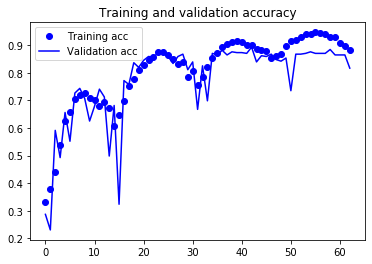

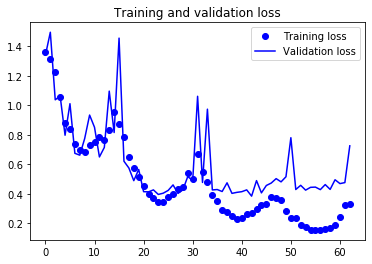

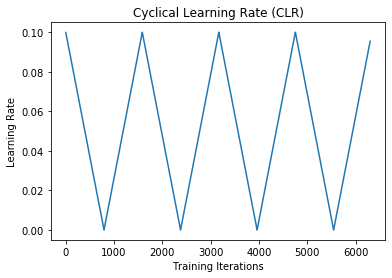

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_ = range(len(acc))

plt.plot(epochs_, acc, 'bo', label='Training acc')
plt.plot(epochs_, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_, loss, 'bo', label='Training loss')
plt.plot(epochs_, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# plot the learning rate history
N = np.arange(0, len(clr.history['lr']))
plt.figure()
plt.plot(N, clr.history['lr'])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")

plt.show()

In [106]:

predictions = model.predict([X_test])

#hot encoding to normal label conversion
predictions_c = []
for i in range(len(predictions)):
    predictions_c.append(np.argmax(predictions[i]))
    
Y_test_c = []
for i in range(len(Y_test)):
    Y_test_c.append(np.argmax(Y_test[i]))

In [107]:
print(Y_test_c[:10])
print(predictions_c[:10])

[1, 0, 1, 3, 0, 2, 2, 2, 0, 3]
[1, 0, 1, 3, 3, 2, 2, 2, 0, 3]


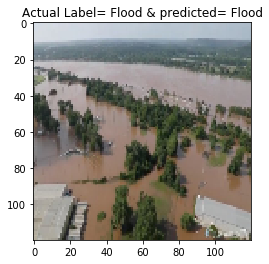

In [116]:
index = 61 #choose any number out of 886
target_names=["Cyclone","Earthquake","Flood","Wildfire"]
plt.imshow(X_test[index])
plt.title("Actual Label= "+str(target_names[np.argmax(Y_test[index])]) +
          " & predicted= "+ str(target_names[np.argmax(predictions[index])]) )
plt.show()

In [109]:
import pandas as pd
Y_test_c = pd.Series(Y_test_c,name='Actual')
predictions_c = pd.Series(predictions_c,name='Predicted')
confusion_matrix_cnn = pd.crosstab(Y_test_c, predictions_c,margins=True)

print("Confusion matrix:\n%s" % confusion_matrix_cnn)

Confusion matrix:
Predicted    0    1    2    3  All
Actual                            
0          185    5    1   11  202
1            4  231   16   12  263
2            4   14  176   14  208
3           12    4    6  191  213
All        205  254  199  228  886


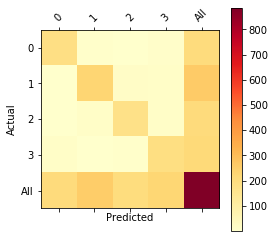

In [115]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.YlOrRd):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(confusion_matrix_cnn)

In [111]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_c, predictions_c, target_names=["Cyclone","Earthquake","Flood","Wildfire"]))

              precision    recall  f1-score   support

     Cyclone       0.90      0.92      0.91       202
  Earthquake       0.91      0.88      0.89       263
       Flood       0.88      0.85      0.86       208
    Wildfire       0.84      0.90      0.87       213

    accuracy                           0.88       886
   macro avg       0.88      0.88      0.88       886
weighted avg       0.88      0.88      0.88       886

